# MACD and RSI Strategy for tech stocks


- Stocks of our interest: AAPl, MSFT, GOOGL, AMZN, NVDA
- Using 14 day period to calculate RSI
- We enter a long position when RSI < 50 and there is bullish crossover based on MACD
- We enter a short position when RSO > 50 and there is bearish crossover based on MACD
- Backtest horizon is from 2015 to 2024, capital is USD 100,000 per stock
- Commission fee is assumed to USD 5 per trade

In [9]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.graph_objects as go

from pandas_datareader import data as pdr
from IPython.display import display

import datetime as dt
import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import metrics

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, ward

from statsmodels.tsa.stattools import coint

from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

## 1. Fetch Data

In [31]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA"]

data = yf.download(tickers, start="2015-01-01", end="2024-12-31")["Close"]



[*********************100%***********************]  5 of 5 completed


In [33]:
data.index = data.index.date


In [35]:
data.head()

Ticker,AAPL,AMZN,GOOGL,MSFT,NVDA
2015-01-02,24.261051,15.4260,26.319653,39.933052,0.483066
2015-01-05,23.577574,15.1095,25.818159,39.565838,0.474906
2015-01-06,23.579790,14.7645,25.180983,38.985119,0.460508
2015-01-07,23.910431,14.9210,25.106924,39.480431,0.459308
2015-01-08,24.829119,15.0230,25.194401,40.641865,0.476586


## 2. Calculate EMA, MACD, Signal Line and RSI

In [61]:

short_window = 12
long_window = 26
signal_window = 9
lookback = 14

def compute_rsi(prices, lookback=14):
    change = prices.diff(1)
    gains = np.where(change > 0, change, 0)
    losses = np.where(change < 0, -change, 0)

    avg_gain = gains[:lookback].mean()
    avg_loss = losses[:lookback].mean()

    rs = avg_gain / avg_loss if avg_loss != 0 else 0
    rsi = np.zeros(len(prices))
    rsi[:lookback] = 100 - (100 / (1 + rs)) if avg_loss != 0 else 100

    for i in range(lookback, len(prices)):
        avg_gain = (avg_gain * (lookback - 1) + gains[i]) / lookback
        avg_loss = (avg_loss * (lookback - 1) + losses[i]) / lookback
        rs = avg_gain / avg_loss if avg_loss != 0 else 0
        rsi[i] = 100 - (100 / (1 + rs)) if avg_loss != 0 else 100

    return pd.Series(rsi, index=prices.index)

In [68]:
indicators = {}

for ticker in tickers:
    df = data[[ticker]].copy()
    df.rename(columns={ticker: "Close"}, inplace=True)

    df["EMA_short"] = df["Close"].ewm(span=short_window, adjust=False).mean()
    df["EMA_long"] = df["Close"].ewm(span=long_window, adjust=False).mean()
    df["MACD"] = df["EMA_short"] - df["EMA_long"]
    df["Signal"] = df["MACD"].ewm(span=signal_window, adjust=False).mean()

    df["RSI"] = compute_rsi(df["Close"], lookback)

    indicators[ticker] = df

In [70]:
print(indicators["MSFT"].head())

Ticker          Close  EMA_short   EMA_long      MACD    Signal        RSI
2015-01-02  39.933052  39.933052  39.933052  0.000000  0.000000  52.387111
2015-01-05  39.565838  39.876558  39.905851 -0.029293 -0.005859  52.387111
2015-01-06  38.985119  39.739413  39.837649 -0.098235 -0.024334  52.387111
2015-01-07  39.480431  39.699570  39.811188 -0.111618 -0.041791  52.387111
2015-01-08  40.641865  39.844538  39.872720 -0.028181 -0.039069  52.387111


## 3. Buy and Sell Signals

In [73]:
for ticker, df in indicators.items():
    # Long signal
    df["Position"] = np.where(
        (df["MACD"] > df["Signal"]) & (df["MACD"].shift() < df["Signal"].shift()) & (df["RSI"] < 50),
        1,
        np.nan
    )
    # Short signal
    df["Position"] = np.where(
        (df["MACD"] < df["Signal"]) & (df["MACD"].shift() > df["Signal"].shift()) & (df["RSI"] > 50),
        -1,
        df["Position"]
    )
    
    indicators[ticker] = df


In [93]:

def plot_signals(df, ticker):

    fig, axs = plt.subplots(3, 1, figsize=(18, 20), sharex=True)

    # Buy sell signals
    buy_signals = df[df['Position'] == 1]
    sell_signals = df[df['Position'] == -1]

    #Close price
    axs[0].plot(df.index, df['Close'], label=f'{ticker} Close Price', color='blue')
    axs[0].scatter(buy_signals.index, buy_signals['Close'] * 0.95, marker='^', color='green', s=100, label='Buy Signal')
    axs[0].scatter(sell_signals.index, sell_signals['Close'] * 1.05, marker='v', color='red', s=100, label='Sell Signal')
    axs[0].set_title(f'{ticker} Close Price with Signals')
    axs[0].set_ylabel('Price')
    axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[0].grid()
    axs[0].text(0.02, 0.9, ticker, transform=axs[0].transAxes, fontsize=12, weight='bold', color='black')

    #MACD
    axs[1].plot(df.index, df['MACD'], label='MACD', color='orange')
    axs[1].plot(df.index, df['Signal'], label='Signal Line', color='purple')
    axs[1].scatter(buy_signals.index, df['MACD'].loc[buy_signals.index] * 0.9, marker='^', color='green', s=100)
    axs[1].scatter(sell_signals.index, df['MACD'].loc[sell_signals.index] * 1.2, marker='v', color='red', s=100)
    axs[1].set_title('MACD & Signal Line')
    axs[1].set_ylabel('MACD')
    axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[1].grid()
    axs[1].text(0.02, 0.9, ticker, transform=axs[1].transAxes, fontsize=12, weight='bold', color='black')

    #RSI
    axs[2].plot(df.index, df['RSI'], label='RSI', color='orange')
    axs[2].axhline(30, color='blue', linestyle='--', label='30')
    axs[2].axhline(50, color='orange', linestyle='--', label='50')
    axs[2].axhline(70, color='red', linestyle='--', label='70')
    axs[2].scatter(buy_signals.index, df['RSI'].loc[buy_signals.index] * 0.9, marker='^', color='green', s=100)
    axs[2].scatter(sell_signals.index, df['RSI'].loc[sell_signals.index] * 1.1, marker='v', color='red', s=100)
    axs[2].set_title('RSI')
    axs[2].set_ylabel('RSI')
    axs[2].set_ylim(0, 100)
    axs[2].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[2].grid()
    axs[2].text(0.02, 0.9, ticker, transform=axs[2].transAxes, fontsize=12, weight='bold', color='black')

    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()


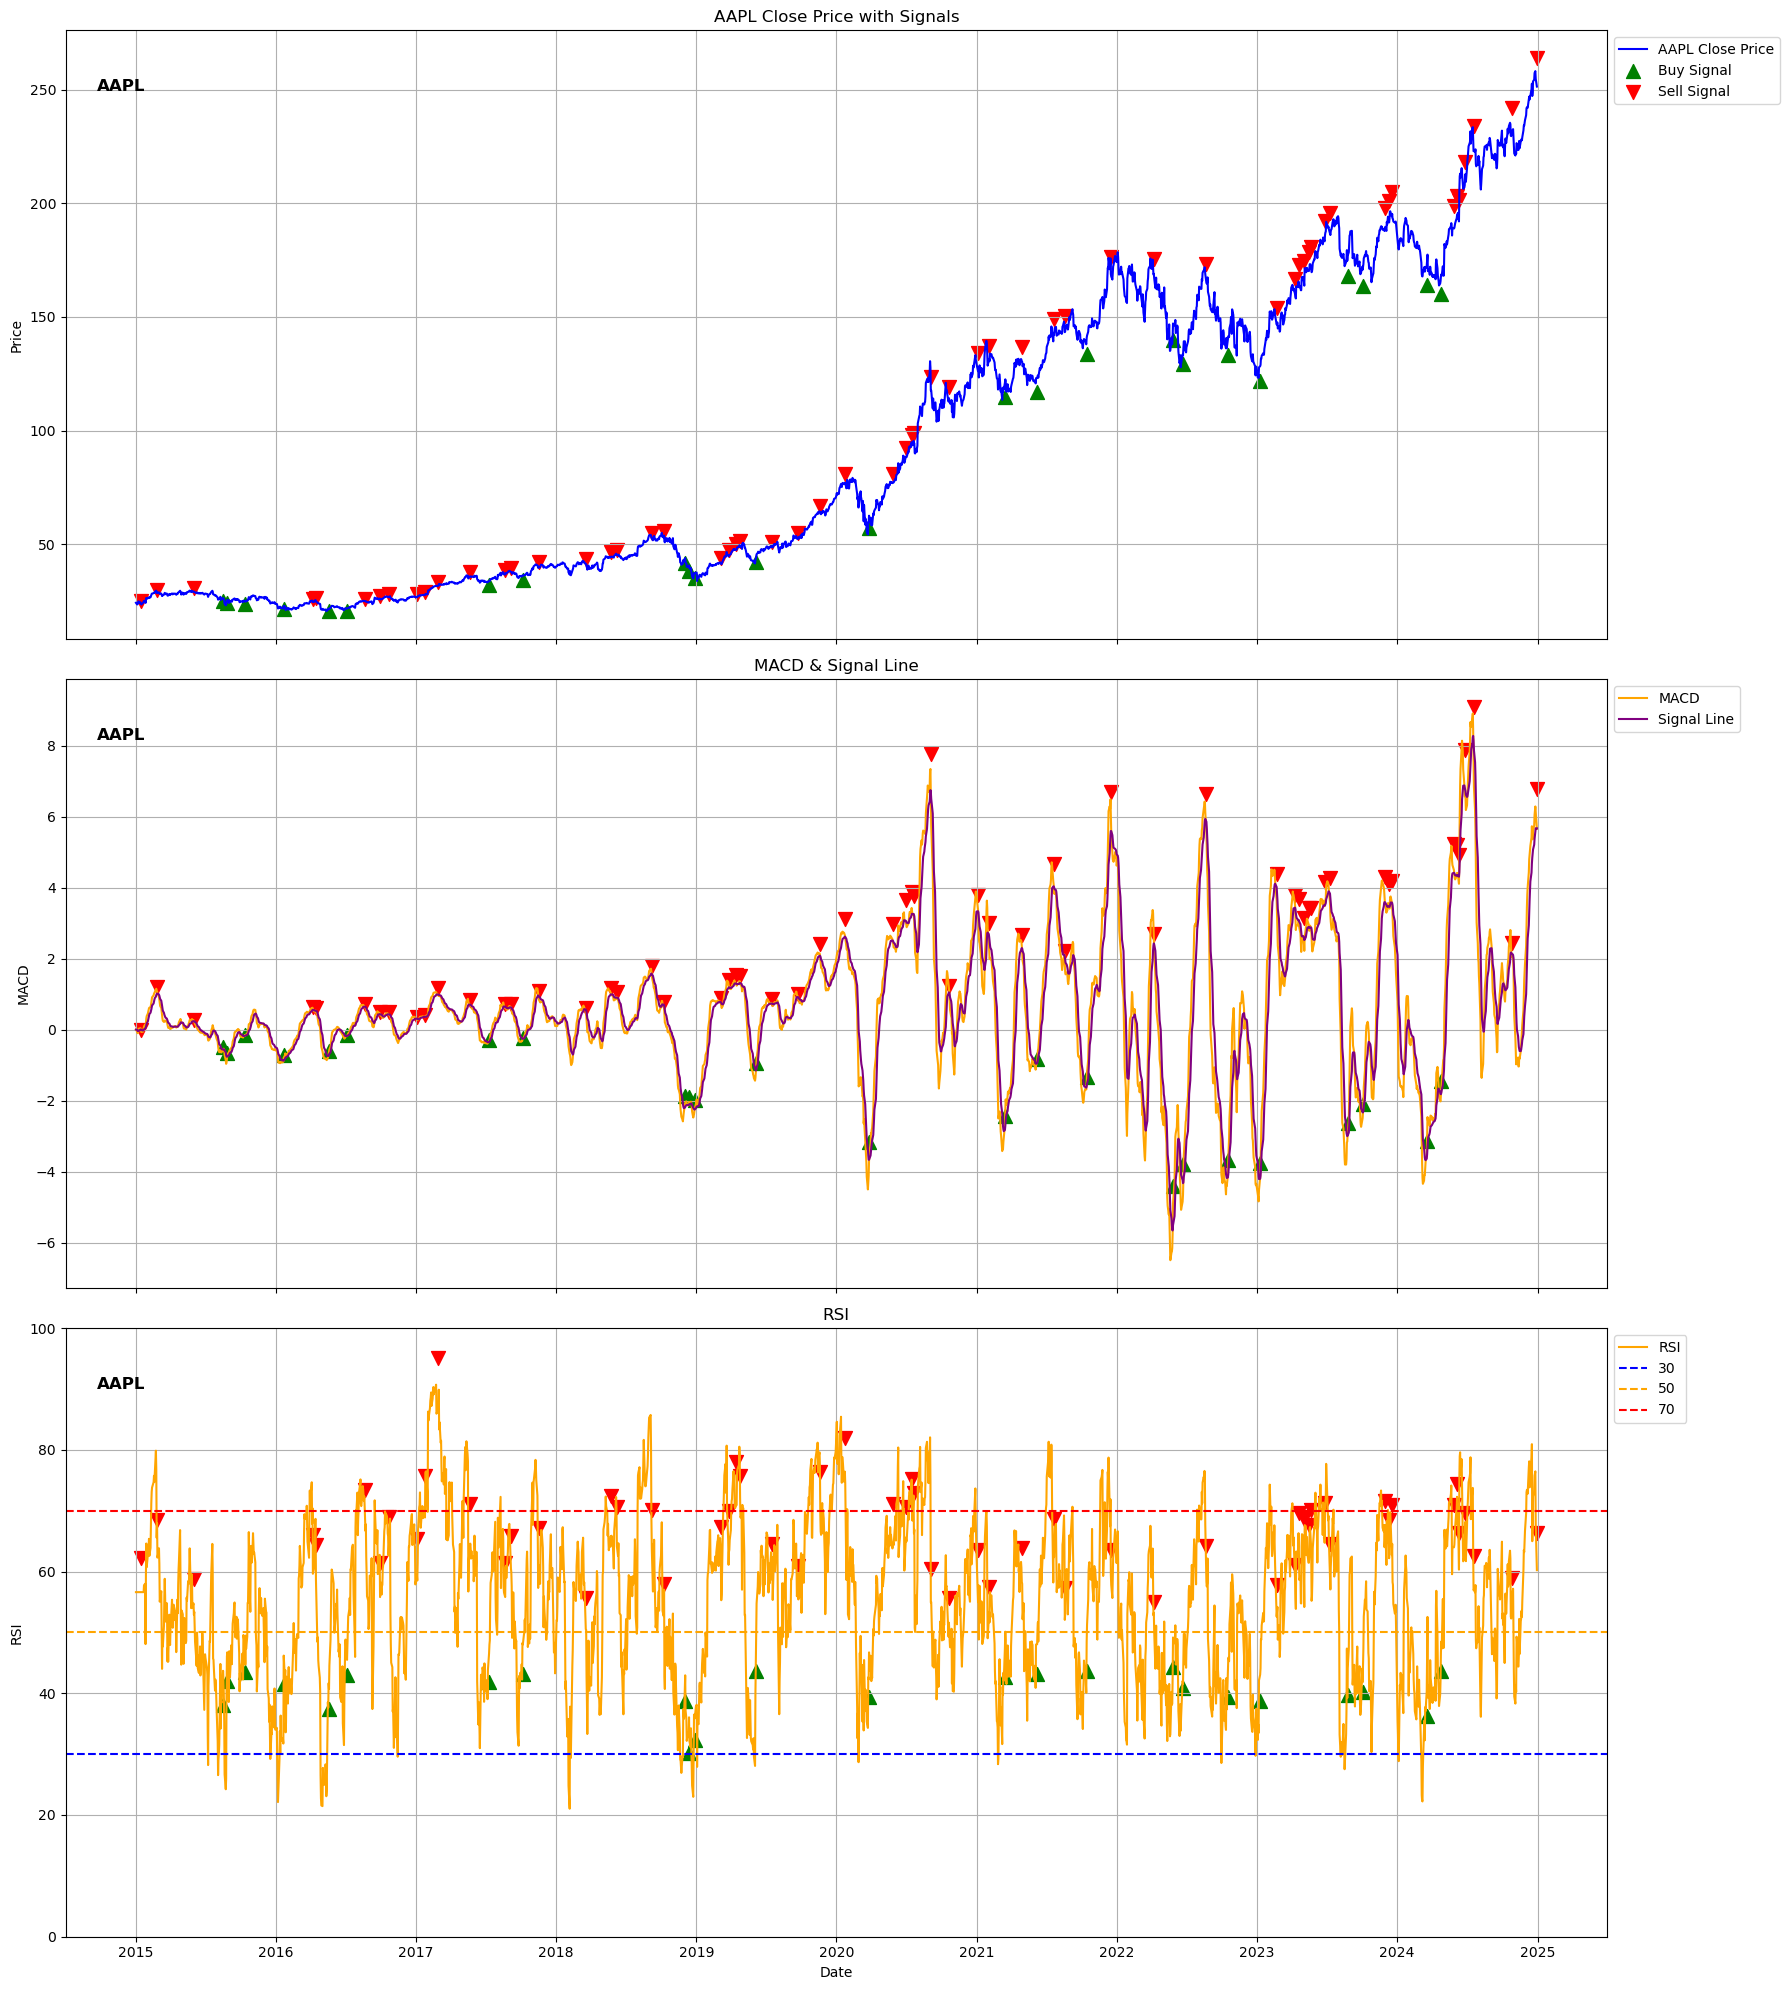

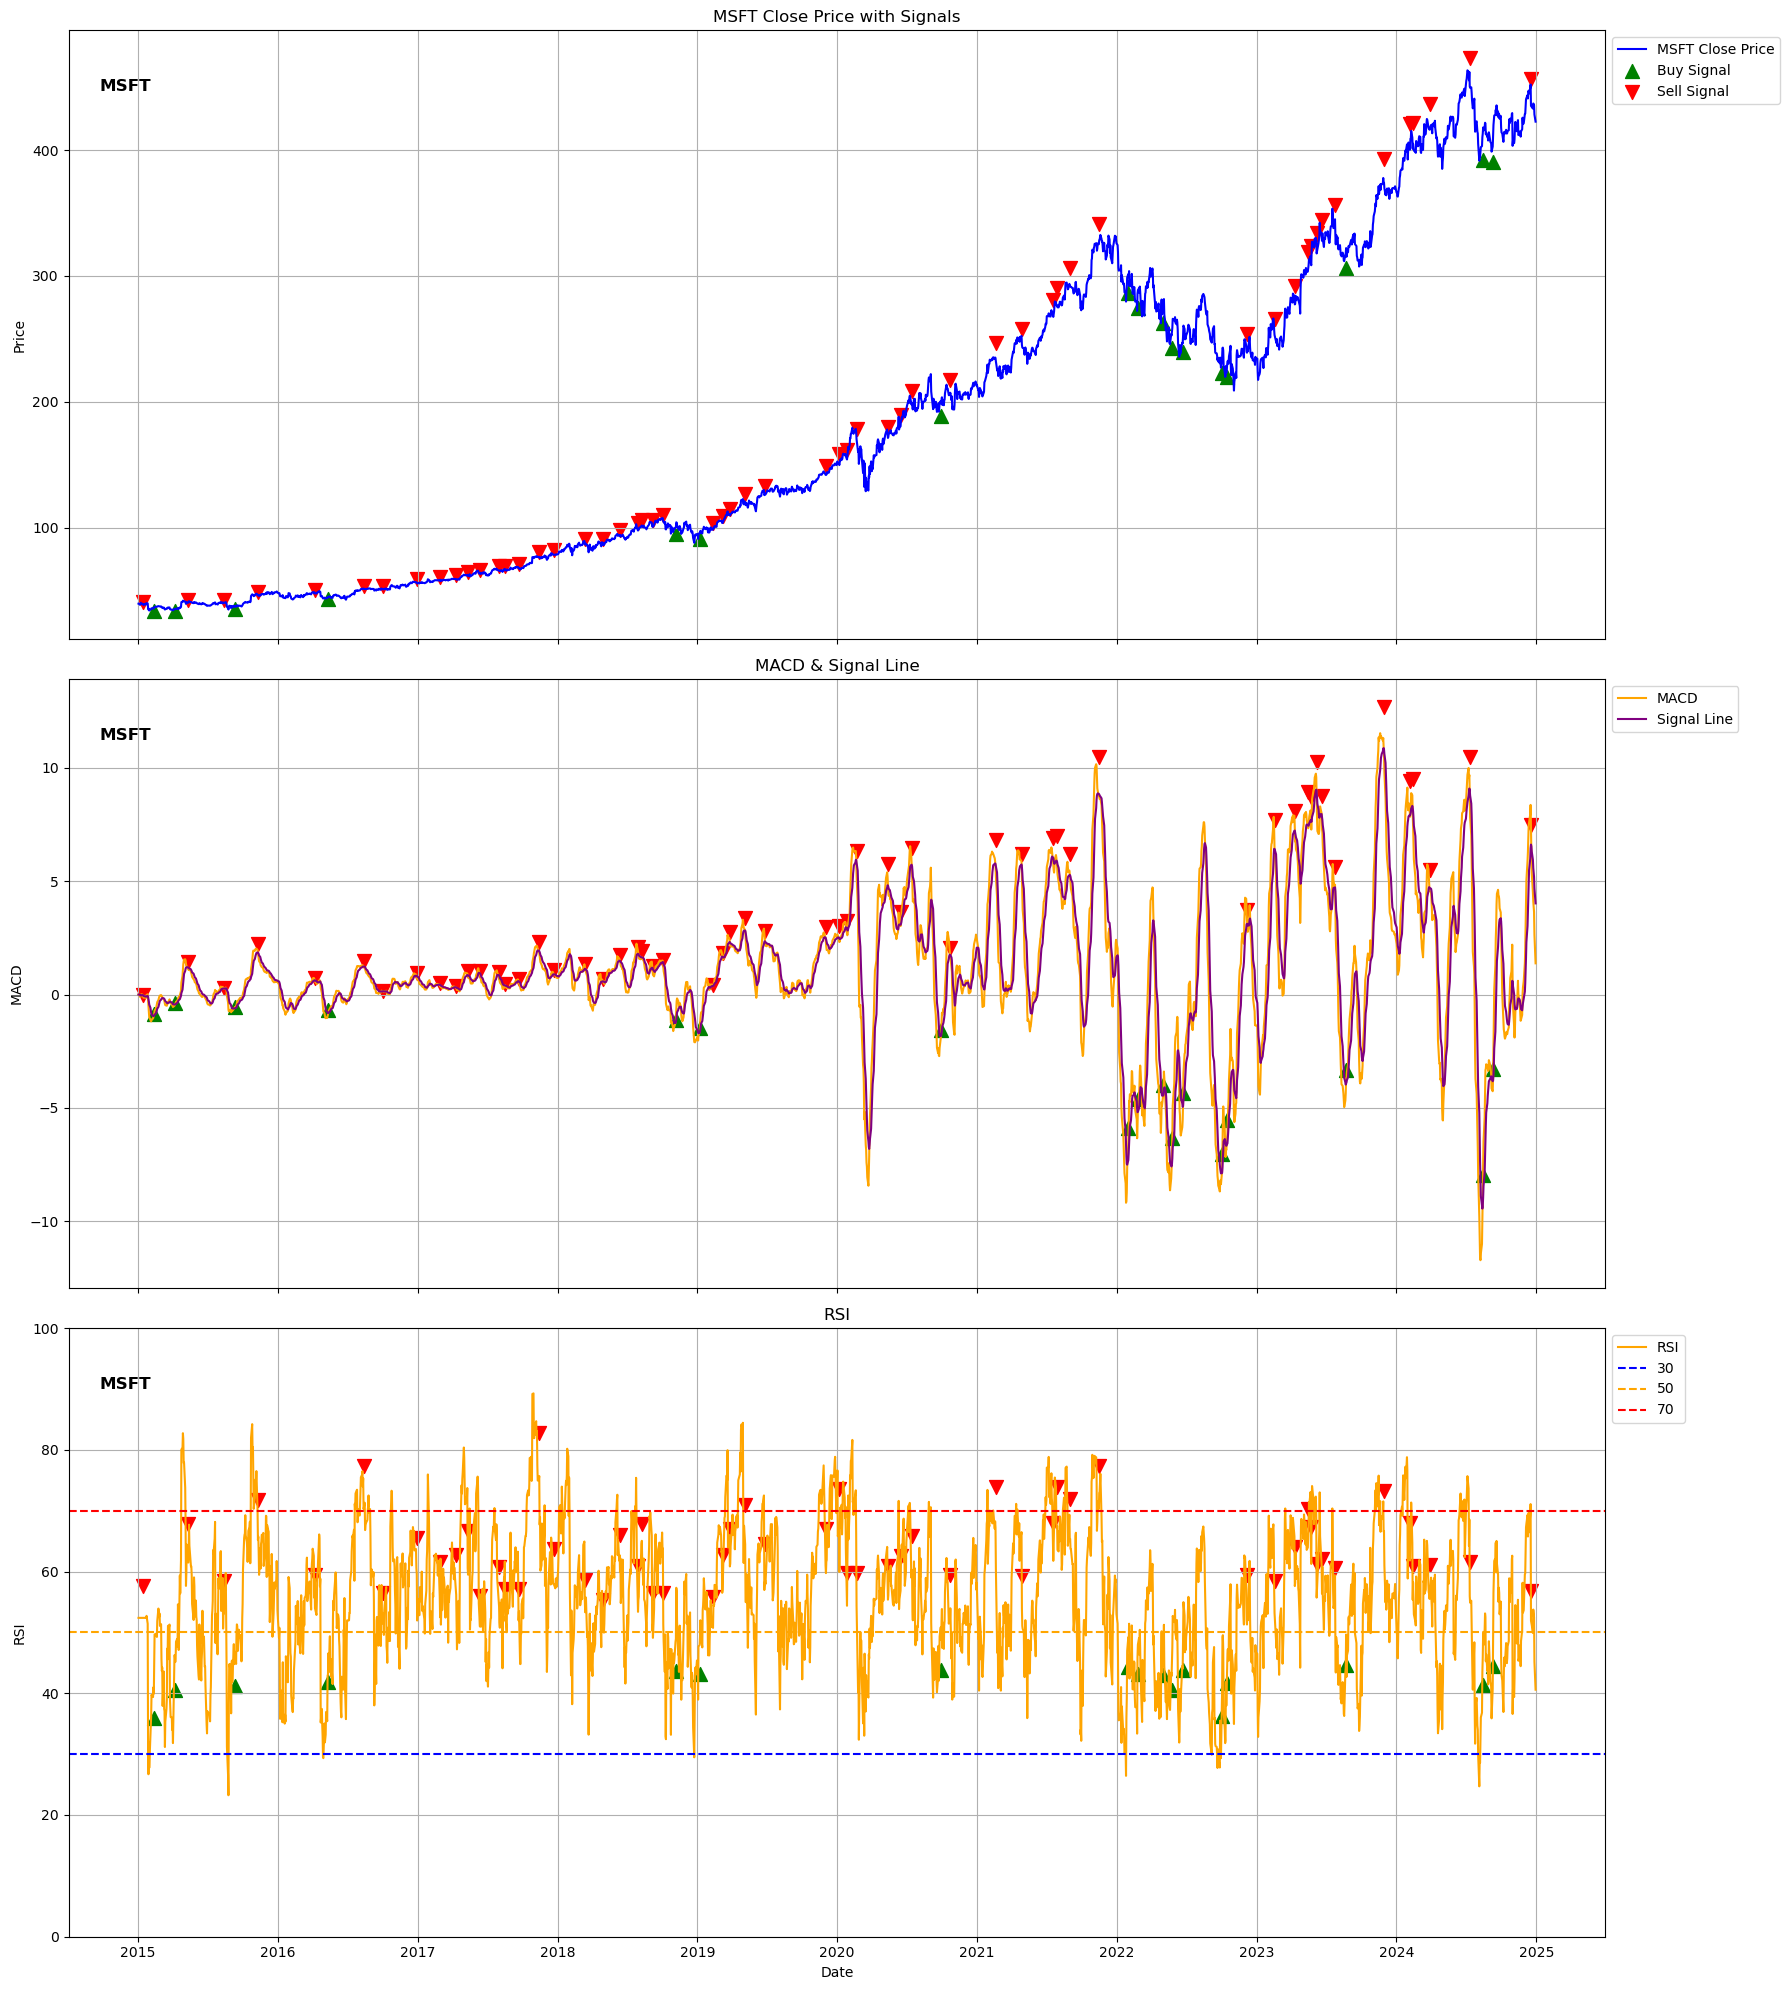

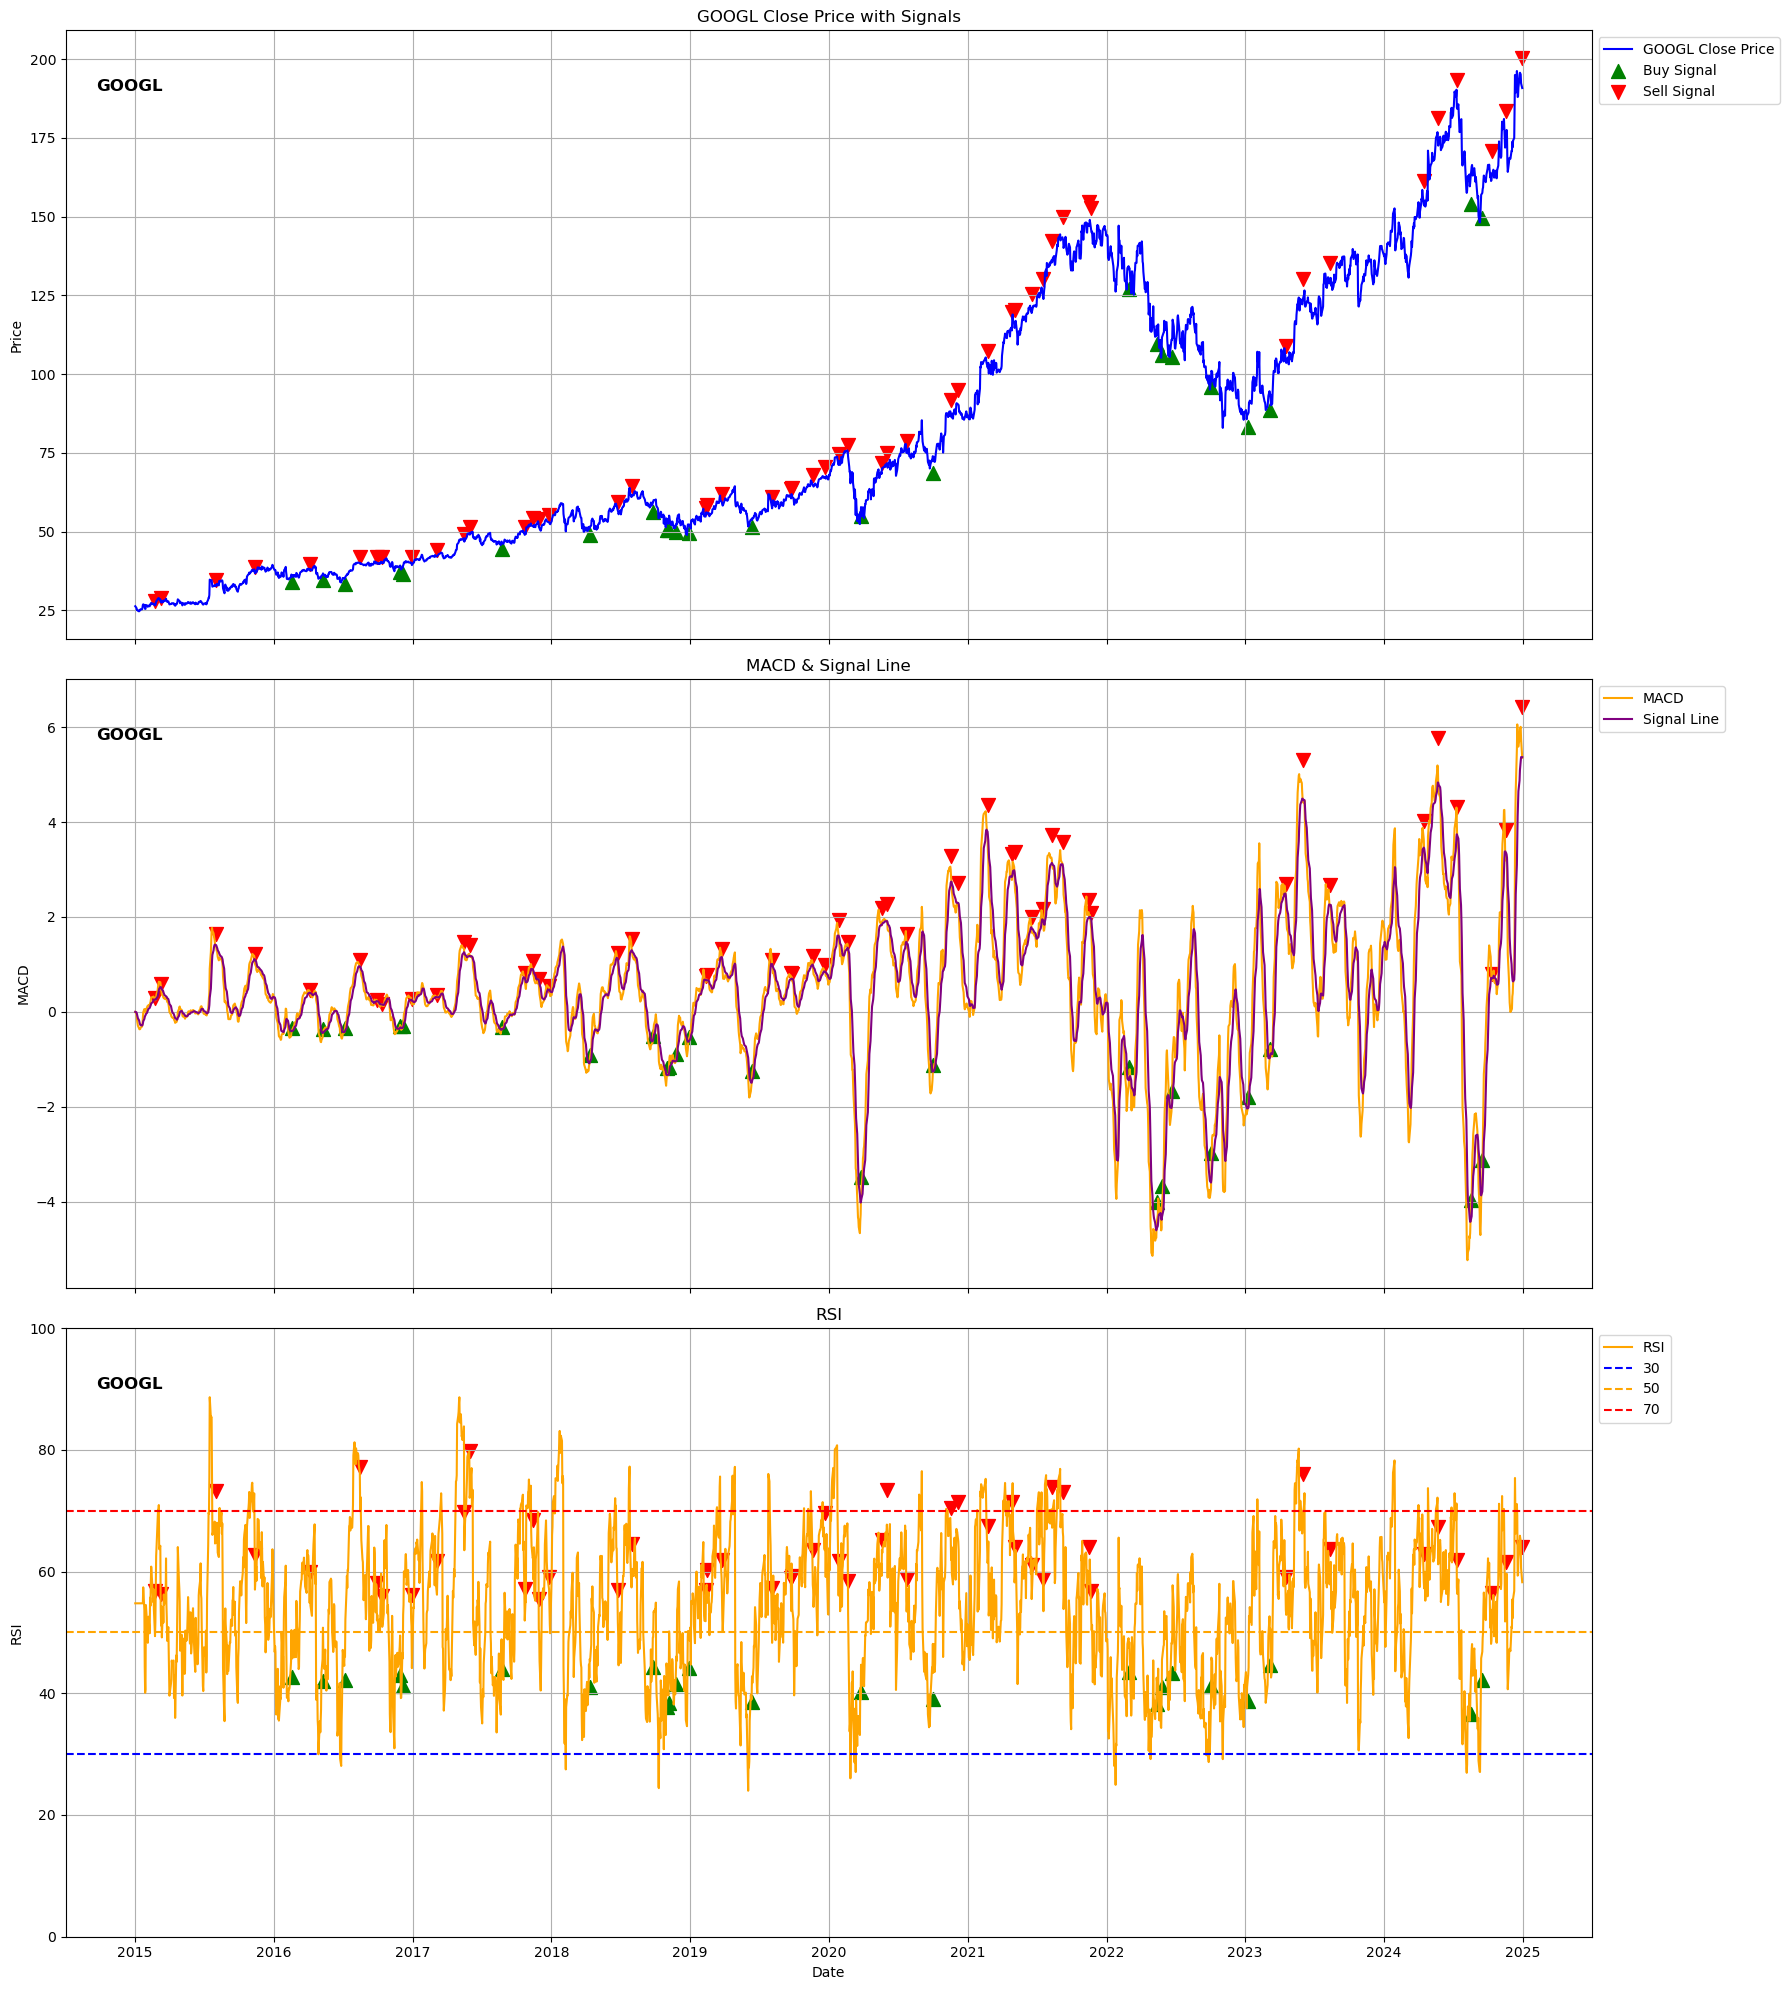

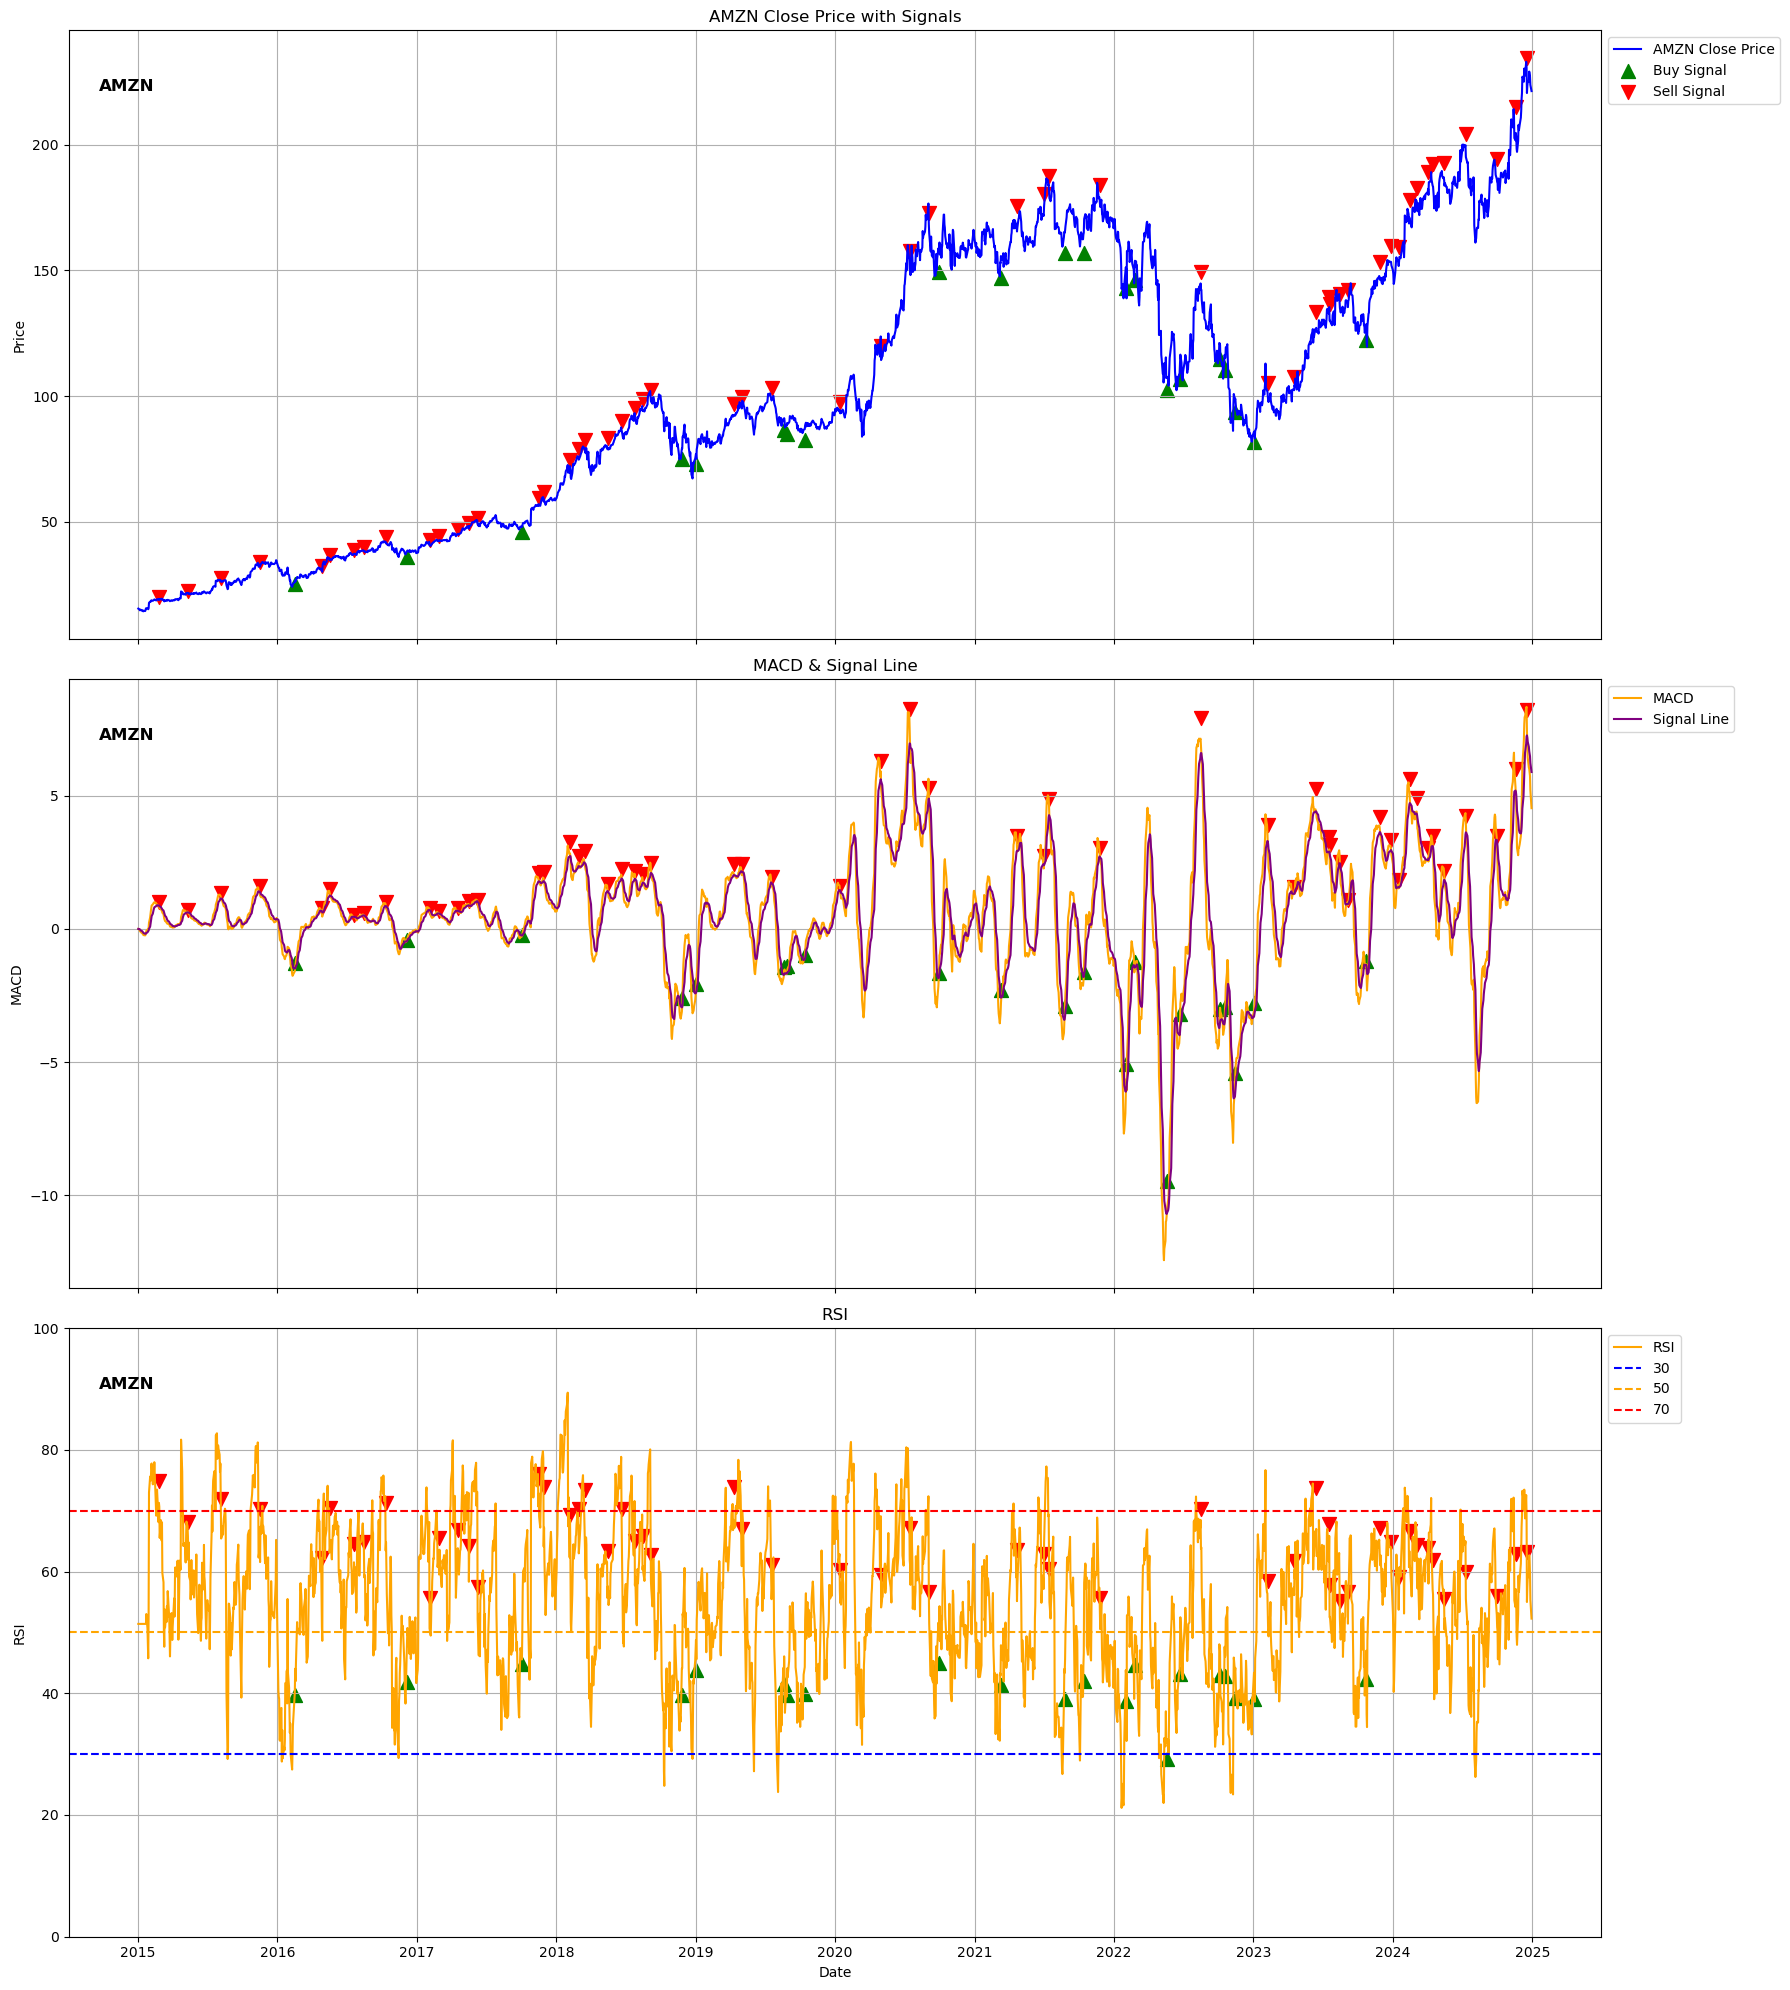

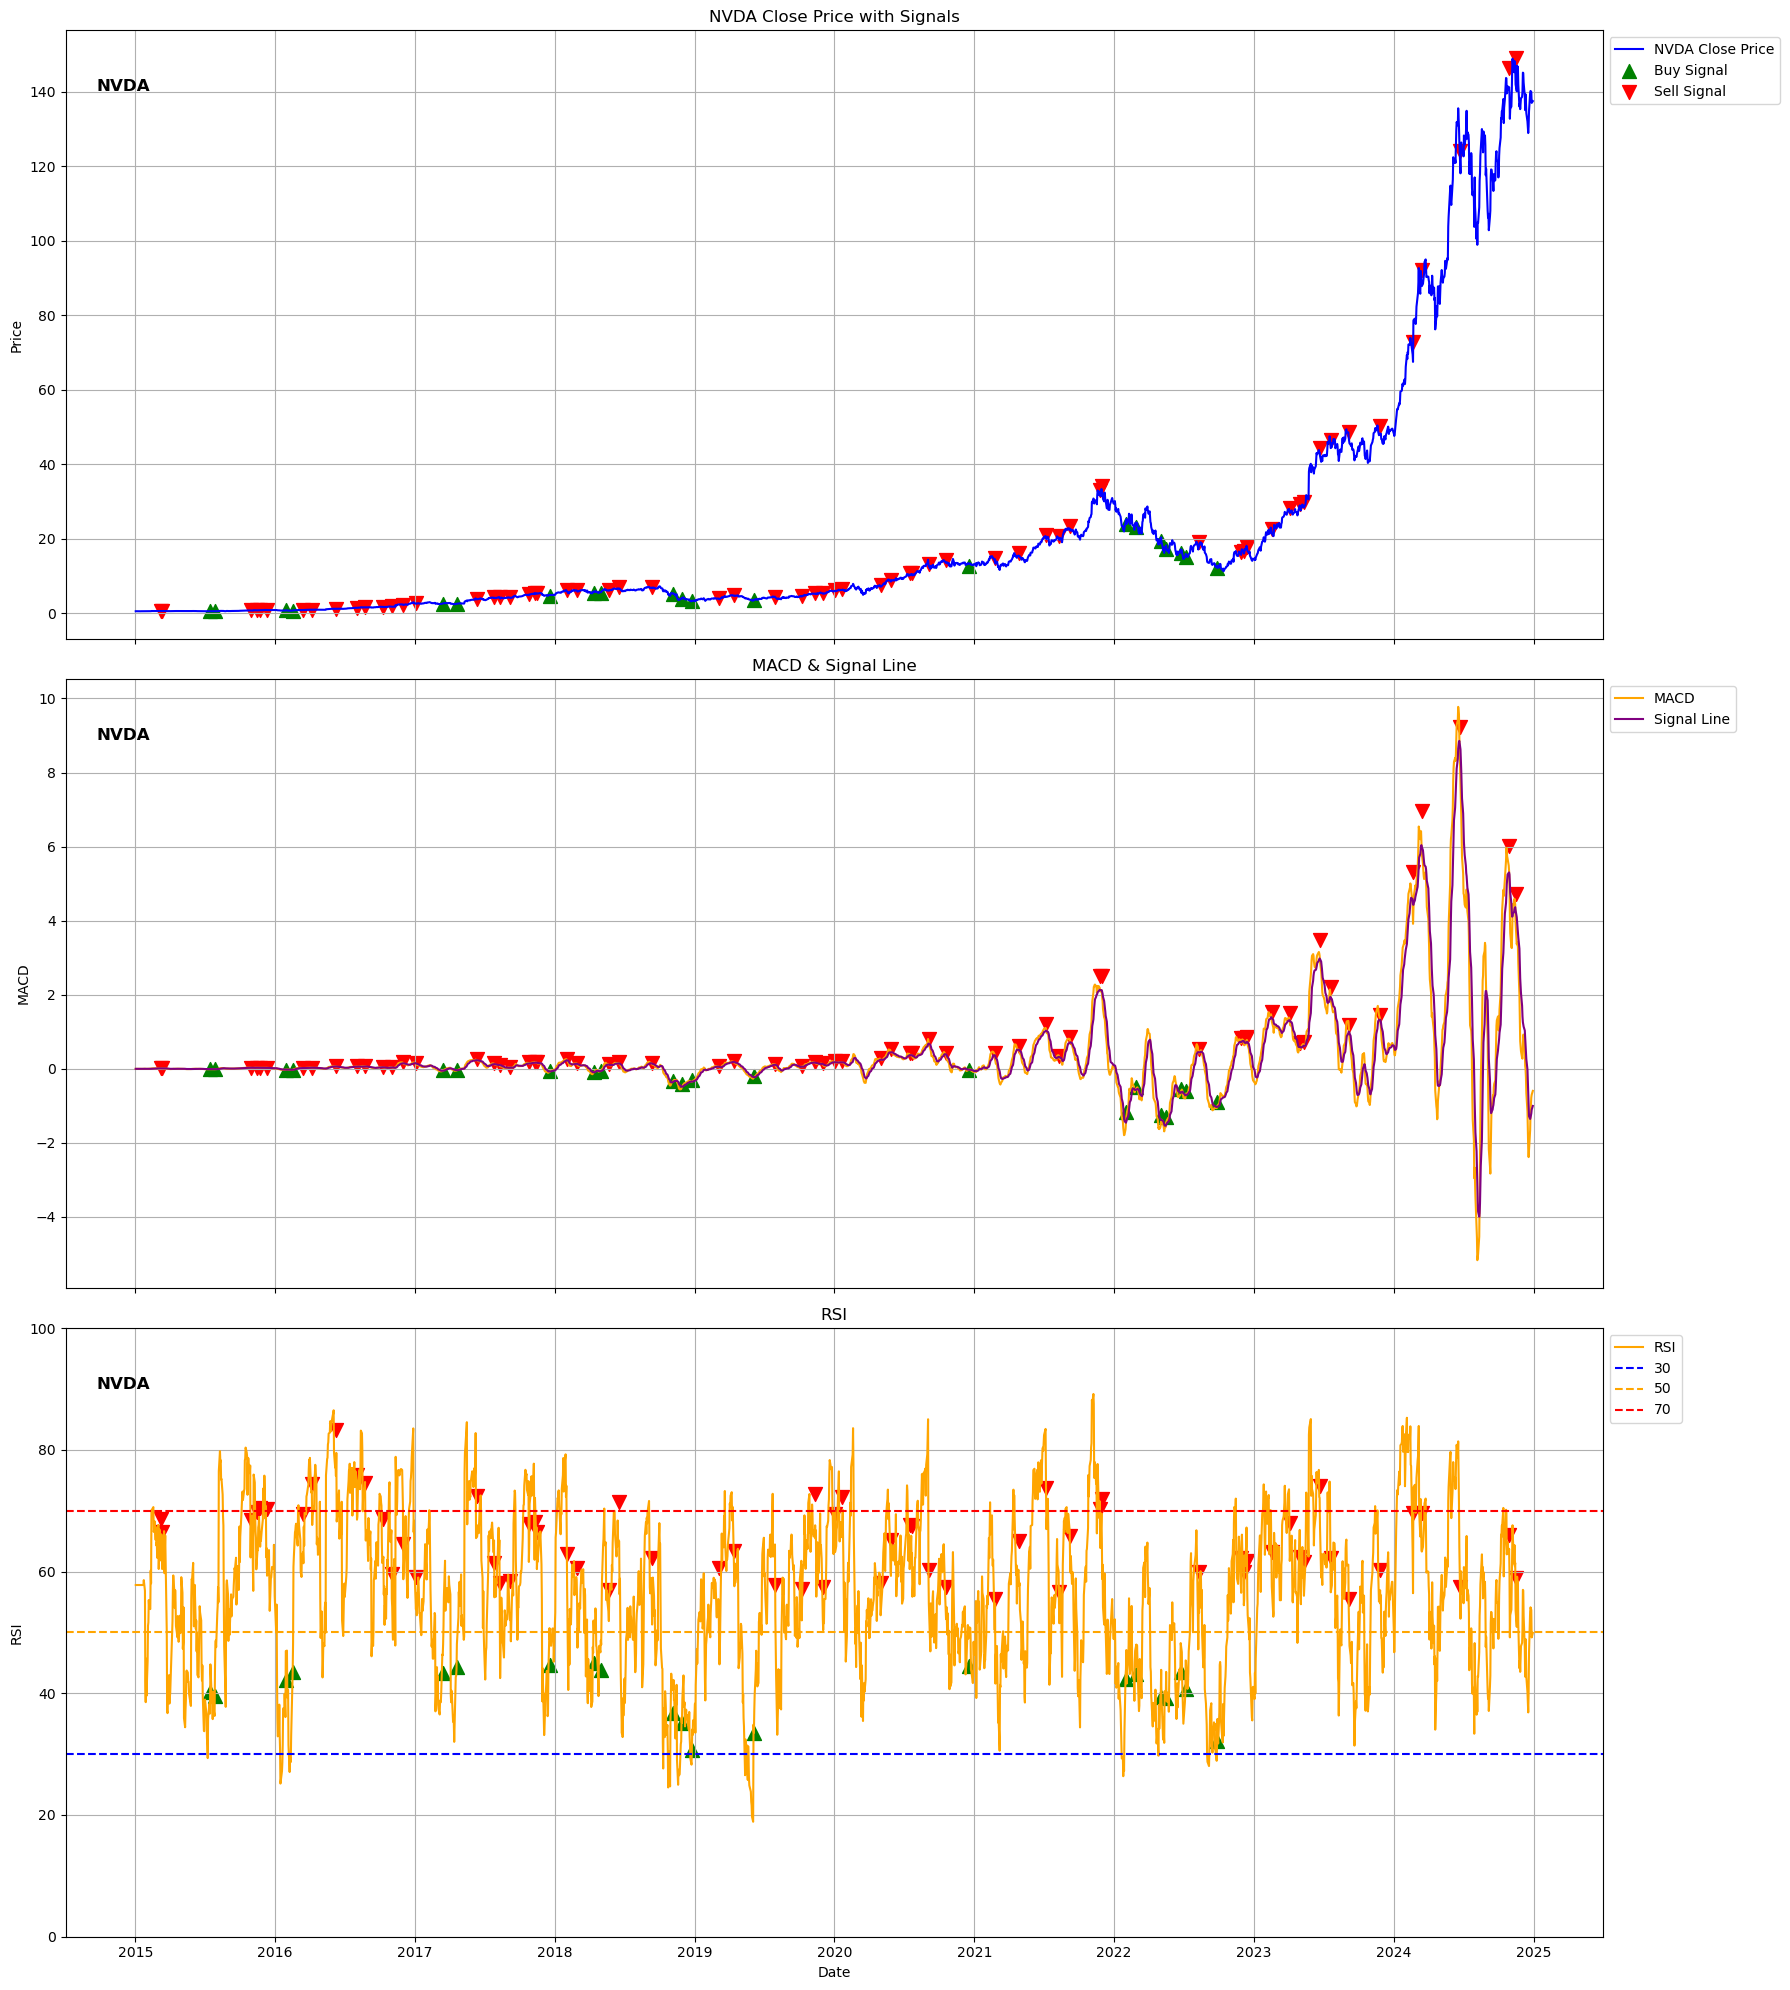

In [95]:
for ticker in tickers:
    plot_signals(indicators[ticker], ticker)


## 4. Backtest Performance

### 4.1. Cumulative Returns

In [99]:
results = {}
summary = []

start_capital = 1e5

for t in tickers:
    df = pd.DataFrame({t: data[t]})

    
    df["commissions"] = np.where(pd.isna(indicators[t]["Position"]), 0.0, 5.0)

    # log returns for stock
    df["Returns_%"] = np.log(df[t] / df[t].shift(1))

    # strategy returns 
    df["Strategy_Returns_%"] = indicators[t]["Position"].shift(1) * df["Returns_%"]

    # cumulative returns
    df["Returns_Cumsum"] = np.exp(df["Returns_%"].cumsum())
    df["Strategy_Returns_Cumsum"] = np.exp(df["Strategy_Returns_%"].cumsum())

    # capital loop
    df["capital"] = np.nan
    df.iloc[0, df.columns.get_loc("capital")] = start_capital
    c = df.columns.get_loc("capital")
    com = df.columns.get_loc("commissions")
    strat = df.columns.get_loc("Strategy_Returns_%")

    for i in range(1, len(df)):
        prev_cap = df.iloc[i-1, c]
        fee = df.iloc[i, com]
        r = df.iloc[i, strat]
        r = 0.0 if pd.isna(r) else r
        df.iloc[i, c] = (prev_cap - fee) * (1 + r)

    
    cum_return = (df.iloc[-1, c] / df.iloc[0, c] - 1) * 100

    results[t] = df
    summary.append({"Ticker": t, "Final_Capital": df["capital"].iloc[-1], "Final_Return_%": cum_return})

summary = pd.DataFrame(summary).set_index("Ticker").sort_values("Final_Return_%", ascending=False)
print(summary)


        Final_Capital  Final_Return_%
Ticker                               
MSFT    104654.126713        4.654127
AAPL    101892.373740        1.892374
AMZN     98684.005299       -1.315995
GOOGL    84458.638606      -15.541361
NVDA     72848.913785      -27.151086


### 4.2 Annalised Sharpe Ratio

In [104]:
sharpe_ratios = {}

for t, df in results.items():
    sr = (
        df["Strategy_Returns_%"].mean() /
        df["Strategy_Returns_%"].std()
    ) * np.sqrt(252)
    sharpe_ratios[t] = sr

sharpe_df = pd.DataFrame.from_dict(sharpe_ratios, orient="index", columns=["Sharpe"])
sharpe_df = sharpe_df.sort_values("Sharpe", ascending=False)

print(sharpe_df)

         Sharpe
MSFT   0.852026
AAPL   0.412573
AMZN   0.068240
NVDA  -1.617548
GOOGL -2.520870


### 4.3 Drawdowns

**Largest 10 drawdowns across all stocks**

In [150]:

drawdown_tables = {}
top5_drawdowns = {}

capital = 1e5
commission = 5

for t in tickers:
    df = results[t].copy()

    total_commission = indicators[t]["Position"].value_counts().sum() * commission

    df["cumulative_returns"] = df["Strategy_Returns_Cumsum"] * capital - total_commission
    df["max_gross_performance"] = df["cumulative_returns"].cummax()

    df["drawdown_abs"]  = df["max_gross_performance"] - df["cumulative_returns"]
    df["drawdown_perc"] = df["drawdown_abs"] / df["max_gross_performance"]
    df["drawdown"]      = -df["drawdown_perc"]  # keep your sign convention (0 at peaks)

    dd_peaks = pd.concat([df[df["drawdown"] == 0], df.tail(1)], axis=0).sort_index()

    lst_day, lst_drawdown = [], []
    for i in range(len(dd_peaks) - 1):
        start = dd_peaks.index[i]
        end   = dd_peaks.index[i + 1]
        days = (end - start).days
        max_dd = df.loc[start:end, "drawdown_perc"].max()
        lst_day.append(days)
        lst_drawdown.append(max_dd)

    drawdown = pd.DataFrame({"days": lst_day, "drawdown": lst_drawdown})
    drawdown_tables[t]  = drawdown
    top5_drawdowns[t]   = drawdown.loc[drawdown["drawdown"].nlargest(5).index]

    results[t] = df

all_dd = []
for t, tbl in drawdown_tables.items():
    tmp = tbl.copy()
    tmp["Ticker"] = t
    all_dd.append(tmp)
all_drawdowns = pd.concat(all_dd, ignore_index=True)

print(all_drawdowns.sort_values("drawdown", ascending=False).head(10))



    days  drawdown Ticker
60  1978  0.441826   NVDA
48  2224  0.163670   AMZN
38  2922  0.155318  GOOGL
35   678  0.146462   MSFT
17   286  0.113583   AAPL
1   2043  0.085551   AAPL
54   150  0.071754   NVDA
25  1018  0.050804   MSFT
52   514  0.049866   NVDA
39  1010  0.033864   AMZN


#### 4.3.1 Drawdown Plots

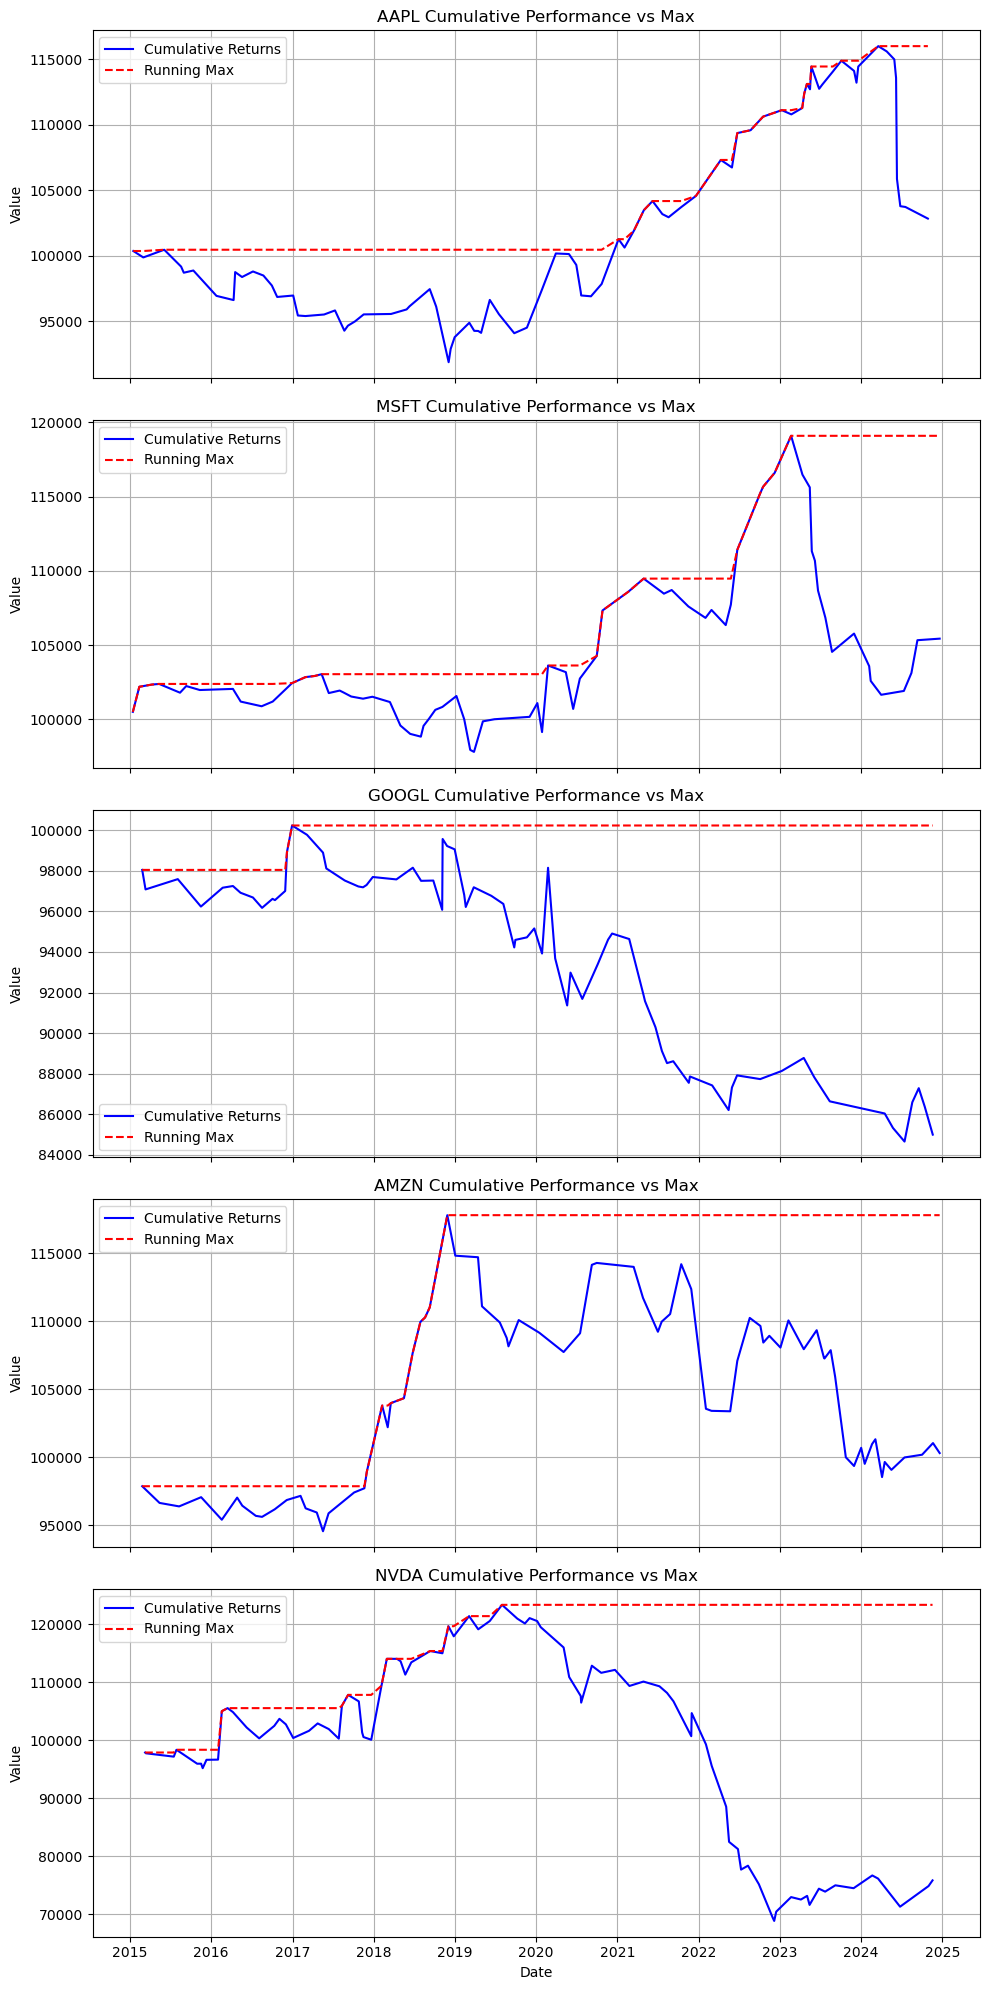

In [155]:
fig, axs = plt.subplots(len(tickers), 1, figsize=(10, 4*len(tickers)), sharex=True)

for i, t in enumerate(tickers):
    df = results[t][["cumulative_returns", "max_gross_performance"]].dropna()
    axs[i].plot(df.index, df["cumulative_returns"],        label="Cumulative Returns", color="blue")
    axs[i].plot(df.index, df["max_gross_performance"],     label="Running Max",        color="red", linestyle="--")
    axs[i].set_title(f"{t} Cumulative Performance vs Max")
    axs[i].set_ylabel("Value")
    axs[i].legend(loc="best")
    axs[i].grid(True)

plt.xlabel("Date")
plt.tight_layout()
plt.show()